# 0.0 IMPORTS

## 01. Libraries

In [25]:
import datetime
import warnings
import inflection
import pandas as pd
import numpy as np
import scipy.stats  as ss

from IPython.display         import Image
from IPython.core.display    import HTML

import matplotlib.pyplot as plt
import seaborn as sns


# 0.2 Notebook Config

In [28]:
def jupyter_settings():
    %matplotlib inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML('<style>.container { width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    warnings.filterwarnings("ignore")
    
    sns.set()

In [29]:
seed = 42
np.random.seed(seed)

jupyter_settings()

## 0.3 Helper Functions

In [37]:
# Time Decorator
def timer(function):
    def wrapper(get):
        try:
            start = datetime.datetime.now()
            function(get)
            end = datetime.datetime.now()
            delta  = end - start
            print('runtime: ', delta)
            return delta
        except:
            pass
    return wrapper


#@timer
def statistical_summary(num_attributes):
    ### Central Tendency -> Mean, Median, Mode
    ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
    ct2 = pd.DataFrame(num_attributes.apply(np.median)).T
    ct3 = pd.DataFrame(ss.mode(num_attributes)[0])
    ct3.columns = ct1.columns

    ### Dispersion -> std, min, max, range, skew, kurtosis, rsd
    d1 = pd.DataFrame(num_attributes.apply(np.std)).T
    d2 = pd.DataFrame(num_attributes.apply(min)).T
    d3 = pd.DataFrame(num_attributes.apply(max)).T
    d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
    d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
    d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T
    d7 = d1 / ct1
    
    # Quantile
    q05 = pd.DataFrame(num_attributes.quantile(0.05)).T
    q10 = pd.DataFrame(num_attributes.quantile(0.10)).T
    q25 = pd.DataFrame(num_attributes.quantile(0.25)).T
    q75 = pd.DataFrame(num_attributes.quantile(0.75)).T
    q90 = pd.DataFrame(num_attributes.quantile(0.90)).T
    q95 = pd.DataFrame(num_attributes.quantile(0.95)).T

    # Concatenate
    m = pd.concat([d2, d3, d4, ct3, ct1, ct2, q05, q10, q25, q75, q90, q95, d1, d7, d5, d6]).T.reset_index()
    m.columns = ['Attributes', 'Mni', 'Max', 'Range', 'Mode', 'Mean', 'Median', '5%', '10%', '25%', '75%', '90%', '95%', 'Std','Relative Std', 'Skew', 'Kurtosis']
    
    return m

## 0.4 Load Data

### 0.4.1 Load Raw Data

In [4]:
data_train_raw = pd.read_feather('../00-Data/feather_data/train.feather')
data_producto_raw = pd.read_feather('../00-Data/feather_data/producto_tabla.feather')
data_cliente_raw = pd.read_feather('../00-Data/feather_data/cliente_tabla.feather')
data_town_state_raw = pd.read_feather('../00-Data/feather_data/town_state.feather')

### 0.4.2 Merge Dataset

In [5]:
data_raw = pd.merge(data_train_raw, data_producto_raw, how='left', on='Producto_ID')
data_raw = pd.merge(data_raw, data_cliente_raw, how='left', on='Cliente_ID')
data_raw = pd.merge(data_raw, data_town_state_raw, how='left', on='Agencia_ID')
data_raw = data_raw.drop(['Producto_ID', 'Cliente_ID', 'Agencia_ID'], axis=1)
data_raw.head()

,Semana,Canal_ID,Ruta_SAK,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,Demanda_uni_equil,NombreProducto,NombreCliente,Town,State
0,3,7,3301,3,25.14,0,0.0,3,Roles Canela 2p 120g BIM 1212,PUESTO DE PERIODICOS LAZARO,2008 AG. LAGO FILT,"MÉXICO, D.F."
1,3,7,3301,4,33.52,0,0.0,4,Roles Glass 2p 135g BIM 1216,PUESTO DE PERIODICOS LAZARO,2008 AG. LAGO FILT,"MÉXICO, D.F."
2,3,7,3301,4,39.32,0,0.0,4,Panquecito Gota Choc 2p 140g BIM 1238,PUESTO DE PERIODICOS LAZARO,2008 AG. LAGO FILT,"MÉXICO, D.F."
3,3,7,3301,4,33.52,0,0.0,4,Mantecadas Vainilla 4p 125g BIM 1240,PUESTO DE PERIODICOS LAZARO,2008 AG. LAGO FILT,"MÉXICO, D.F."
4,3,7,3301,3,22.92,0,0.0,3,Donitas Espolvoreadas 6p 105g BIM 1242,PUESTO DE PERIODICOS LAZARO,2008 AG. LAGO FILT,"MÉXICO, D.F."


# 1.0 DATA DESCRIPTION

In [6]:
df01 = data_raw.copy()

## 1.1 Columns

In [7]:
df01.columns

Index(['Semana', 'Canal_ID', 'Ruta_SAK', 'Venta_uni_hoy', 'Venta_hoy',
       'Dev_uni_proxima', 'Dev_proxima', 'Demanda_uni_equil', 'NombreProducto',
       'NombreCliente', 'Town', 'State'],
      dtype='object')

### 1.2.1 Rename Columns

In [8]:
snakecase = lambda col: inflection.underscore(col)

new_columns = list(map(snakecase, df01.columns))

# rename
df01.columns = new_columns

### 1.2.2 New Name Columns

In [9]:
df01.columns

Index(['semana', 'canal_id', 'ruta_sak', 'venta_uni_hoy', 'venta_hoy',
       'dev_uni_proxima', 'dev_proxima', 'demanda_uni_equil',
       'nombre_producto', 'nombre_cliente', 'town', 'state'],
      dtype='object')

## 1.3 Data Dimensions

In [10]:
print(f'Number of Rows: {df01.shape[0]}')
print(f'Number of Columns: {df01.shape[1]}')

Number of Rows: 74773833
Number of Columns: 12


## 1.4 Data Types

In [11]:
df01.dtypes

semana                 int64
canal_id               int64
ruta_sak               int64
venta_uni_hoy          int64
venta_hoy            float64
dev_uni_proxima        int64
dev_proxima          float64
demanda_uni_equil      int64
nombre_producto       object
nombre_cliente        object
town                  object
state                 object
dtype: object

## 1.5 Missing Values

In [12]:
for col in df01.columns.tolist():
    print(col, df01[col].isnull().sum())

semana 0
canal_id 0
ruta_sak 0
venta_uni_hoy 0
venta_hoy 0
dev_uni_proxima 0
dev_proxima 0
demanda_uni_equil 0
nombre_producto 0
nombre_cliente 0
town 0
state 0


### 1.5.2 ~~Fillout NA~~

there is no NA values

## 1.6 Descriptive Statistical

In [14]:
# Numerical Attributes
num_attributes = df01.select_dtypes(include=['int64', 'float64'])

In [36]:
## Statatistical Summary (Helper Function)
statistical_summary(num_attributes)

runtime:  0:04:05.392211


datetime.timedelta(seconds=245, microseconds=392211)

In [ ]:
## Statatistical Summary (Helper Function)
statistical_summary(num_attributes)

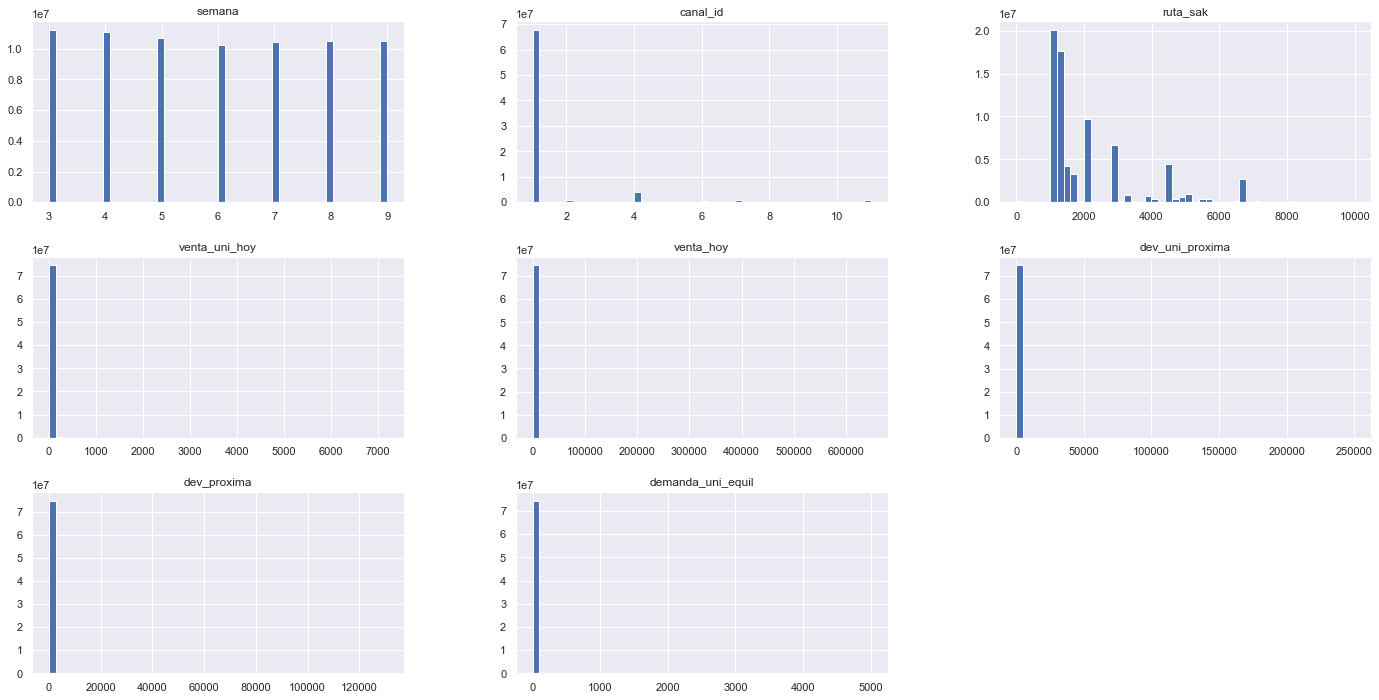

In [31]:
num_attributes.hist(bins=50, figsize=(24,12));